In [ ]:
# Market Regime Detection Using Machine Learning

#This project builds a machine learning system to detect market regimes 
#(bull vs bear) using technical indicators and price action features.

#The model is used as a risk filter for trading strategies.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download GOLD data
# You can change to "BTC-USD" later if you want
data = yf.download("GLD", start="2005-01-01")

print(data.shape)
print(data.head())

# Use only adjusted close system
df = data.copy()
df.columns = df.columns.droplevel(1) if isinstance(df.columns, pd.MultiIndex) else df.columns
df.columns = df.columns.str.lower()

df = df[['open', 'high', 'low', 'close', 'volume']]

df.head()


[*********************100%***********************]  1 of 1 completed

(5286, 5)
Price           Close       High        Low       Open   Volume
Ticker            GLD        GLD        GLD        GLD      GLD
Date                                                           
2005-01-03  43.020000  43.169998  42.740002  42.980000  4750400
2005-01-04  42.740002  42.910000  42.459999  42.799999  3456800
2005-01-05  42.669998  42.880001  42.599998  42.750000  2033600
2005-01-06  42.150002  42.560001  42.070000  42.480000  2556400
2005-01-07  41.840000  42.389999  41.700001  42.090000  4492700


Price,open,high,low,close,volume
Date,,,,,
2005-01-03,42.980000,43.169998,42.740002,43.020000,4750400
2005-01-04,42.799999,42.910000,42.459999,42.740002,3456800
2005-01-05,42.750000,42.880001,42.599998,42.669998,2033600
2005-01-06,42.480000,42.560001,42.070000,42.150002,2556400
2005-01-07,42.090000,42.389999,41.700001,41.840000,4492700


In [3]:
# === Feature 1: Returns ===
df["return"] = df["close"].pct_change()
df["log_return"] = np.log(df["close"] / df["close"].shift(1))

# === Trend filters ===
df["ma_20"] = df["close"].rolling(20).mean()
df["ma_50"] = df["close"].rolling(50).mean()
df["ma_200"] = df["close"].rolling(200).mean()

# === Volatility ===
df["vol_20"] = df["return"].rolling(20).std()

# === Candle features ===
df["range"] = (df["high"] - df["low"]) / df["close"]
df["body"] = (df["close"] - df["open"]) / df["close"]

# === REGIME TARGET ===
# 1 = Bull regime, 0 = Bear regime
df["regime"] = (df["close"] > df["ma_200"]).astype(int)

# Drop NaNs from rolling windows
df = df.dropna()

df.tail()


Price,open,high,low,close,volume,return,log_return,ma_20,ma_50,ma_200,vol_20,range,body,regime
Date,,,,,,,,,,,,,,
2025-12-30,403.600006,403.799988,398.559998,398.890015,10179000,0.000728,0.000727,396.742001,384.152600,331.49895,0.012671,0.013136,-0.011808,1
2025-12-31,398.600006,400.130005,395.589996,396.309998,10194700,-0.006468,-0.006489,397.195502,384.015800,332.09685,0.012671,0.011456,-0.005778,1
2026-01-02,401.619995,401.820007,396.250000,398.279999,10372600,0.004971,0.004959,397.765501,384.436600,332.68845,0.012687,0.013985,-0.008386,1
2026-01-05,406.390015,409.720001,406.149994,408.760010,13410600,0.026313,0.025973,398.847002,385.066201,333.32670,0.013839,0.008734,0.005798,1
2026-01-06,410.670013,413.480011,410.309998,413.179993,11601200,0.010813,0.010755,400.184001,385.754000,333.98885,0.013905,0.007672,0.006075,1


In [4]:
features = [
    "return",
    "log_return",
    "ma_20",
    "ma_50",
    "ma_200",
    "vol_20",
    "range",
    "body"
]

X = df[features]
y = df["regime"]

print(X.shape, y.shape)
print(y.value_counts(normalize=True))


(5087, 8) (5087,)
regime
1    0.684686
0    0.315314
Name: proportion, dtype: float64


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=False
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (3815, 8) Test: (1272, 8)


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

models = {
    "Logistic": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    
    "RandomForest": RandomForestClassifier(
        n_estimators=500,
        max_depth=6,
        min_samples_leaf=20,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
}

for name, model in models.items():
    print("\nTraining", name)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]
    
    print(classification_report(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, probs))



Training Logistic
              precision    recall  f1-score   support

           0       0.67      0.99      0.79       357
           1       0.99      0.81      0.89       915

    accuracy                           0.86      1272
   macro avg       0.83      0.90      0.84      1272
weighted avg       0.90      0.86      0.86      1272

ROC AUC: 0.9718326674932268

Training RandomForest
              precision    recall  f1-score   support

           0       0.98      0.26      0.42       357
           1       0.78      1.00      0.87       915

    accuracy                           0.79      1272
   macro avg       0.88      0.63      0.64      1272
weighted avg       0.83      0.79      0.74      1272

ROC AUC: 0.7606098176975709


In [7]:
# Use Logistic model
best_model = models["Logistic"]

# Get probabilities & predictions
probs = best_model.predict_proba(X_test)[:,1]
preds = best_model.predict(X_test)

# Create trading signal: 1 = long, 0 = cash
signals = pd.Series(preds, index=X_test.index)

signals.value_counts()


1    743
0    529
Name: count, dtype: int64

In [8]:
# Market returns
test_returns = df.loc[X_test.index, "return"]

# Strategy returns: only earn returns when signal == 1
strategy_returns = signals.shift(1) * test_returns

# Cumulative curves
cum_strategy = (1 + strategy_returns.fillna(0)).cumprod()
cum_market = (1 + test_returns).cumprod()

print("Strategy return:", cum_strategy.iloc[-1])
print("Buy & Hold return:", cum_market.iloc[-1])


Strategy return: 2.0315418056944274
Buy & Hold return: 2.399837353023265


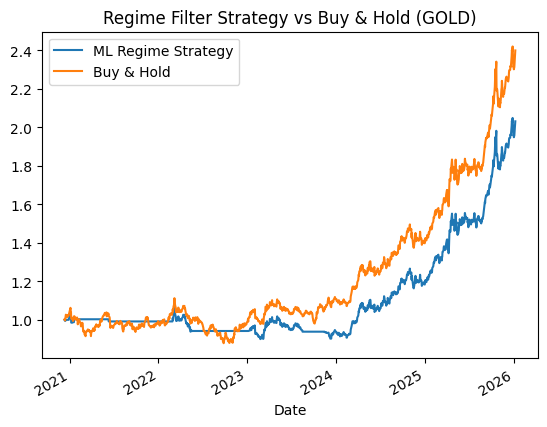

In [9]:
import matplotlib.pyplot as plt

cum_strategy.plot(label="ML Regime Strategy")
cum_market.plot(label="Buy & Hold")

plt.title("Regime Filter Strategy vs Buy & Hold (GOLD)")
plt.legend()
plt.show()


In [11]:
def sharpe(returns):
    return np.sqrt(252) * returns.mean() / returns.std()

print("Market Sharpe:", sharpe(test_returns))
print("Strategy Sharpe:", sharpe(strategy_returns))


# Max drawdown
def max_drawdown(curve):
    peak = curve.cummax()
    dd = (curve - peak) / peak
    return dd.min()

print("Market Max DD:", max_drawdown(cum_market))
print("Strategy Max DD:", max_drawdown(cum_strategy))


Market Sharpe: 1.188868290288788
Strategy Sharpe: 1.150342127551549
Market Max DD: -0.21032844203783338
Strategy Max DD: -0.1548310428738819


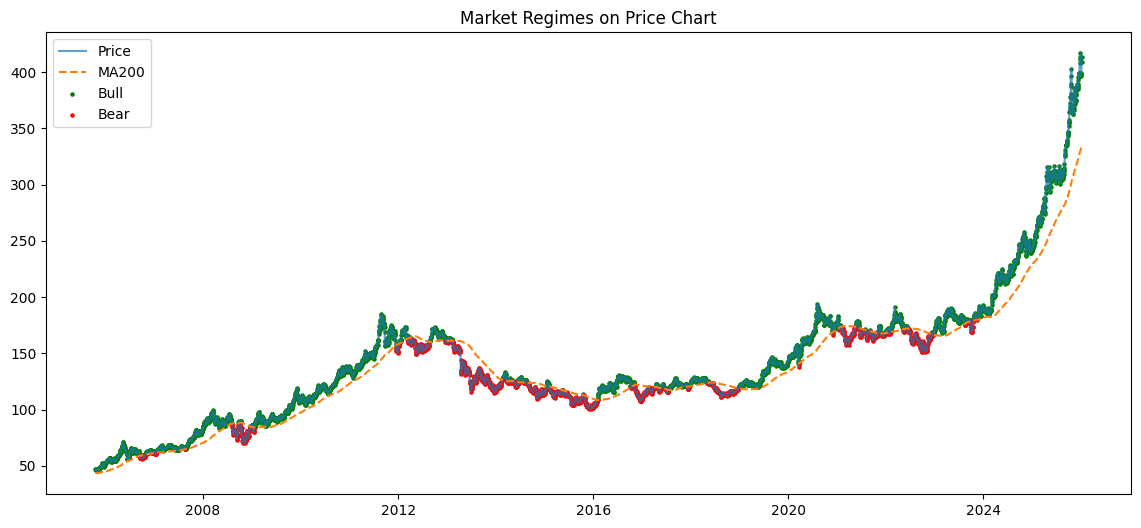

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.plot(df.index, df["close"], label="Price", alpha=0.7)
plt.plot(df.index, df["ma_200"], label="MA200", linestyle="--")

bull = df["regime"] == 1
bear = df["regime"] == 0

plt.scatter(df.index[bull], df["close"][bull], color="green", s=5, label="Bull")
plt.scatter(df.index[bear], df["close"][bear], color="red", s=5, label="Bear")

plt.title("Market Regimes on Price Chart")
plt.legend()
plt.show()


In [21]:
features = [
    "log_return",
    "ma_20", "ma_50", "ma_200",
    "vol_20",
    "range", "body"
]

X = df[features]
y = df["regime"]


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=False
)

print(X_train.shape, X_test.shape)


(3815, 7) (1272, 7)


In [24]:
from sklearn.ensemble import RandomForestClassifier

final_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    random_state=42
)

final_model.fit(X_train, y_train)

print("Base model trained.")


Base model trained.


In [25]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(final_model, method="isotonic", cv=5)
calibrated_model.fit(X_train, y_train)

print("Calibrated model trained.")


Calibrated model trained.


In [26]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(final_model, method="isotonic", cv=5)
calibrated_model.fit(X_train, y_train)

print("Calibrated model trained.")


Calibrated model trained.


In [27]:
label, conf = predict_today(df, calibrated_model)

print("================================")
print("📅 Date:", df.index[-1].date())
print("📊 Market Regime:", label)
print("📈 Confidence:", round(conf * 100, 2), "%")
print("================================")


📅 Date: 2026-01-06
📊 Market Regime: BULL
📈 Confidence: 58.79 %


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

def walk_forward_backtest(df, features, target, start_train_size=1500, step=250):
    all_signals = pd.Series(index=df.index, dtype=float)
    
    for i in range(start_train_size, len(df)-step, step):
        train = df.iloc[:i]
        test = df.iloc[i:i+step]
        
        X_train = train[features]
        y_train = train[target]
        X_test = test[features]
        
        base_model = LogisticRegression(max_iter=1000)
        model = CalibratedClassifierCV(base_model, method="sigmoid", cv=5)
        model.fit(X_train, y_train)
        
        probs = model.predict_proba(X_test)
        preds = model.predict(X_test)
        
        signals = pd.Series(index=test.index, dtype=float)
        
        # Regime strategy:
        # 1 = long, 0 = flat
        signals[preds == 1] = 1
        signals[preds == 0] = 0
        
        all_signals.loc[test.index] = signals
    
    all_signals = all_signals.fillna(0)
    return all_signals


In [29]:
features = ["log_return", "ma_20", "ma_50", "ma_200", "vol_20", "range", "body"]
target = "regime"

wf_signals = walk_forward_backtest(df, features, target)
wf_signals.value_counts()


0.0    3087
1.0    2000
Name: count, dtype: int64

In [30]:
features = ["log_return", "ma_20", "ma_50", "ma_200", "vol_20", "range", "body"]
target = "regime"

wf_signals = walk_forward_backtest(df, features, target)
wf_signals.value_counts()


0.0    3087
1.0    2000
Name: count, dtype: int64

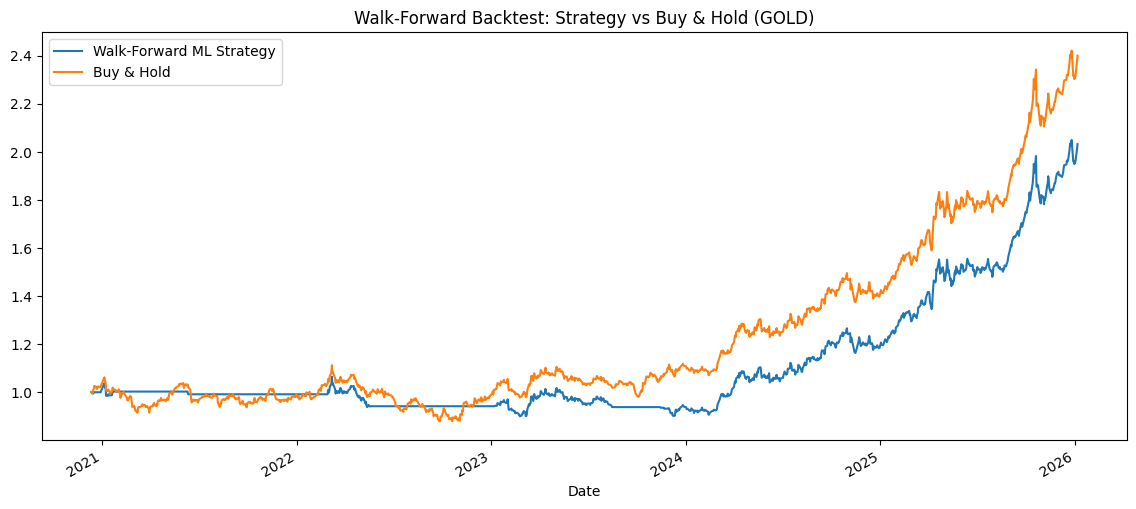

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
cum_strategy.plot(label="Walk-Forward ML Strategy")
cum_market.plot(label="Buy & Hold")

plt.title("Walk-Forward Backtest: Strategy vs Buy & Hold (GOLD)")
plt.legend()
plt.show()


In [33]:
market_returns = df["log_return"]

print("Market Sharpe:", sharpe(market_returns))
print("Strategy Sharpe:", sharpe(strategy_returns))

print("Market Max DD:", max_drawdown(cum_market))
print("Strategy Max DD:", max_drawdown(cum_strategy))


Market Sharpe: 0.6026715619040666
Strategy Sharpe: 1.150342127551549
Market Max DD: -0.21032844203783338
Strategy Max DD: -0.1548310428738819
